# Boston House Price Prediction with Random Forest Regression

Задача следующая: агентство недвижимости столкнулось с проблемой — риелторы тратят слишком много времени на сортировку объявлений и поиск выгодных предложений. Поэтому скорость их реакции и качество анализа не дотягивают до уровня конкурентов. Это сказывается на финансовых показателях агентства.

Ваша цель — разработать модель машинного обучения, которая поможет обрабатывать объявления и увеличит число сделок и прибыль агентства.

необходимо:
1. Провести разведывательный анализ и очистку исходных данных. Обратите
внимание, что данные в таблице реальные: в результате во многих
признаках присутствуют дублирующиеся категории, ошибки ввода,
жаргонные сокращения и т .д. Вам предстоит отыскать закономерности,
самостоятельно расшифровать все сокращения, найти синонимы в
данных, обработать пропуски и удалить выбросы.
Постарайтесь уделить этапу очистки максимум внимания, так как это
напрямую повлияет на результаты моделирования.
2. Выделить наиболее значимые факторы, влияющие на стоимость
недвижимости.
3. Построить модель для прогнозирования стоимости недвижимости.
4. Разработать небольшой веб-сервис, на вход которому поступают данные
о некоторой выставленной на продажу недвижимости, а сервис
прогнозирует его стоимость.

In [10]:
# !pip install joblib
# !pip install streamlit

In [11]:
# Импорт необходимых библиотек
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import joblib
import warnings
import streamlit as st
import numpy as np
warnings.filterwarnings('ignore')

In [12]:
# Загрузите набор данных
file_path = "data.csv"
df = pd.read_csv(file_path)

# Удалить повторяющиеся строки
df = df.drop_duplicates()

# Удалите столбец «частный пул».
df = df.drop(columns=['private pool', 'homeFacts', 'schools', 'mls-id', 'MlsId', 'street', 'zipcode', 'city'])

# Отобразите первые несколько строк набора данных, чтобы понять его структуру.
df.head()

,status,propertyType,baths,fireplace,sqft,beds,state,stories,PrivatePool,target
0,Active,Single Family Home,3.5,Gas Logs,2900,4,NC,NaN,NaN,"$418,000"
1,for sale,single-family home,3 Baths,NaN,"1,947 sqft",3 Beds,WA,2.0,NaN,"$310,000"
2,for sale,single-family home,2 Baths,yes,"3,000 sqft",3 Beds,CA,1.0,yes,"$2,895,000"
3,for sale,single-family home,8 Baths,yes,"6,457 sqft",5 Beds,TX,3.0,NaN,"$2,395,000"
4,for sale,lot/land,NaN,NaN,NaN,NaN,FL,NaN,NaN,"$5,000"


## Подготовка данных

In [13]:
#форма данных
df.shape

(377135, 10)

In [14]:
# Функция для извлечения числового значения из строки
def extract_num(value):
    if pd.isnull(value):
        return None
    # Используйте регулярное выражение для поиска чисел (целые числа только для кроватей).
    match = re.search(r'\d+', str(value))
    return int(match.group()) if match else None

# Функция для извлечения числового значения из строки
def extract_numeric(value):
    if pd.isnull(value):
        return None
    # Используйте регулярное выражение для поиска чисел (включая запятые и десятичные дроби)
    match = re.search(r'[\d,\.]+', str(value))
    # Удалить запятые и преобразовать в число с плавающей запятой
    return float(match.group().replace(',', '')) if match else None

def transform_fireplace(value):
    #Проверьте, является ли значение числовым и >= 1
    if isinstance(value, (int, float)) and value >= 1:
        return 1
    #Проверьте, является ли значение текстовым и содержит ли оно «камин» или «да»
    elif isinstance(value, str) and ('fireplace' in value.lower() or value.lower() == 'yes'):
        return 1
    # Default case
    return 0

In [15]:
# Примените функцию к столбцу «ванны»
df['baths'] = df['baths'].apply(extract_num)

# Примените функцию к столбцу «кровати»
df['beds'] = df['beds'].apply(extract_num).astype('float')

# Примените функцию к столбцу «кв.фут»
df['sqft'] = df['sqft'].apply(extract_numeric)

# Примените функцию к «целевому» столбцу
df['target'] = df['target'].apply(extract_numeric)

# Замените «да» на 1, «нет» на 0 и NA на 0 в «Частный пул».
df['PrivatePool'] = df['PrivatePool'].replace({'yes': 1, 'Yes': 1, 'no': 0})
df['PrivatePool'] = df['PrivatePool'].fillna(0)

# Замените «Один раз» на 1, а «Два» на 2 в «Историях»
df['stories'] = df['stories'].replace({'One': 1, 'Two': 2})

# Извлекайте только числовые значения из «Историй»
df['stories'] = df['stories'].astype(str).str.extract('(\d+)', expand=False).fillna(0).astype(int)

# Замените «/аукцион» на «Аукцион».
df['status'] = df['status'].replace('/ auction', 'Auction')

# Rпереместите символы, следующие после «:» в «Скоро: 11 декабря».
df['status'] = df['status'].str.replace(r':.*$', '', regex=True)

# Преобразовать столбец в нижний регистр
df['status'] = df['status'].str.lower()

# Примените функцию к столбцу «камин»
df['fireplace'] = df['fireplace'].apply(transform_fireplace)

# Преобразовать все столбцы объекта в нижний регистр
df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)

#проверьте наличие пропущенных значений
print(df.isna().sum())

# Удалить строки с пропущенными значениями
df_cleaned = df.dropna()

df_cleaned

status           39917
propertyType     34733
baths           107808
fireplace            0
sqft             41370
beds            108835
state                0
stories              0
PrivatePool          0
target            2480
dtype: int64


,status,propertyType,baths,fireplace,sqft,beds,state,stories,PrivatePool,target
0,active,single family home,3.0,0,2900.0,4.0,nc,0,0.0,418000.0
1,for sale,single-family home,3.0,0,1947.0,3.0,wa,2,0.0,310000.0
2,for sale,single-family home,2.0,1,3000.0,3.0,ca,1,1.0,2895000.0
3,for sale,single-family home,8.0,1,6457.0,5.0,tx,3,0.0,2395000.0
8,active,single family home,2.0,0,3588.0,3.0,ia,0,0.0,244900.0
...,...,...,...,...,...,...,...,...,...,...
377173,for sale,single-family home,3.0,1,2505.0,5.0,oh,2,0.0,384900.0
377175,for sale,single-family home,3.0,1,1792.0,4.0,tx,2,0.0,280000.0
377179,for sale,condo,3.0,0,1417.0,2.0,dc,3,0.0,799000.0
377181,for sale,condo,3.0,0,2000.0,3.0,il,9,0.0,674999.0


In [16]:
#Проверка дубликатов
df_cleaned.describe(include='all')

,status,propertyType,baths,fireplace,sqft,beds,state,stories,PrivatePool,target
count,208814,208814,208814.00000,208814.000000,2.088140e+05,208814.000000,208814,208814.000000,208814.000000,2.088140e+05
unique,83,23,NaN,NaN,NaN,NaN,34,NaN,NaN,NaN
top,for sale,single-family home,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
freq,154085,80442,NaN,NaN,NaN,NaN,49878,NaN,NaN,NaN
mean,NaN,NaN,2.76367,0.298265,6.362074e+03,3.450904,NaN,1.386195,0.140359,6.883138e+05
std,NaN,NaN,1.53465,0.457498,1.741914e+06,1.495138,NaN,3.287513,0.347360,1.889212e+06
min,NaN,NaN,0.00000,0.000000,0.000000e+00,0.000000,NaN,0.000000,0.000000,1.000000e+00
25%,NaN,NaN,2.00000,0.000000,1.428000e+03,3.000000,NaN,0.000000,0.000000,2.250000e+05
50%,NaN,NaN,2.00000,0.000000,1.944000e+03,3.000000,NaN,1.000000,0.000000,3.500000e+05
75%,NaN,NaN,3.00000,1.000000,2.708000e+03,4.000000,NaN,2.000000,0.000000,6.233698e+05


In [17]:
# проверка на наличие выбросов и их удаление
# Функция удаления выбросов методом IQR
def remove_outliers(df):
    for column in df.select_dtypes(include=['number']).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Отфильтруйте датафрейм, чтобы включить только невыбросы
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

# Удалить выбросы
df_cleaned= remove_outliers(df_cleaned)
df_cleaned.shape

(144669, 10)

## (EDA)

Это предполагает обобщение основных характеристик набора данных, часто с помощью визуальных методов. Мы визуализируем распределение различных характеристик и их взаимосвязь с целевой переменной (MEDV — медианная стоимость домов).
### Одномерный анализ

In [18]:
# сводная статистика
df_cleaned.describe(include='all')

,status,propertyType,baths,fireplace,sqft,beds,state,stories,PrivatePool,target
count,144669,144669,144669.000000,144669.000000,144669.000000,144669.000000,144669,144669.000000,144669.0,144669.000000
unique,81,23,NaN,NaN,NaN,NaN,34,NaN,NaN,NaN
top,for sale,single-family home,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
freq,99769,54628,NaN,NaN,NaN,NaN,32334,NaN,NaN,NaN
mean,NaN,NaN,2.389849,0.270860,1907.883576,3.228881,NaN,1.139525,0.0,335110.975178
std,NaN,NaN,0.728419,0.444405,707.799317,0.803370,NaN,0.928301,0.0,190786.987975
min,NaN,NaN,1.000000,0.000000,0.000000,2.000000,NaN,0.000000,0.0,1.000000
25%,NaN,NaN,2.000000,0.000000,1374.000000,3.000000,NaN,0.000000,0.0,199300.000000
50%,NaN,NaN,2.000000,0.000000,1797.000000,3.000000,NaN,1.000000,0.0,291900.000000
75%,NaN,NaN,3.000000,1.000000,2339.000000,4.000000,NaN,2.000000,0.0,435000.000000


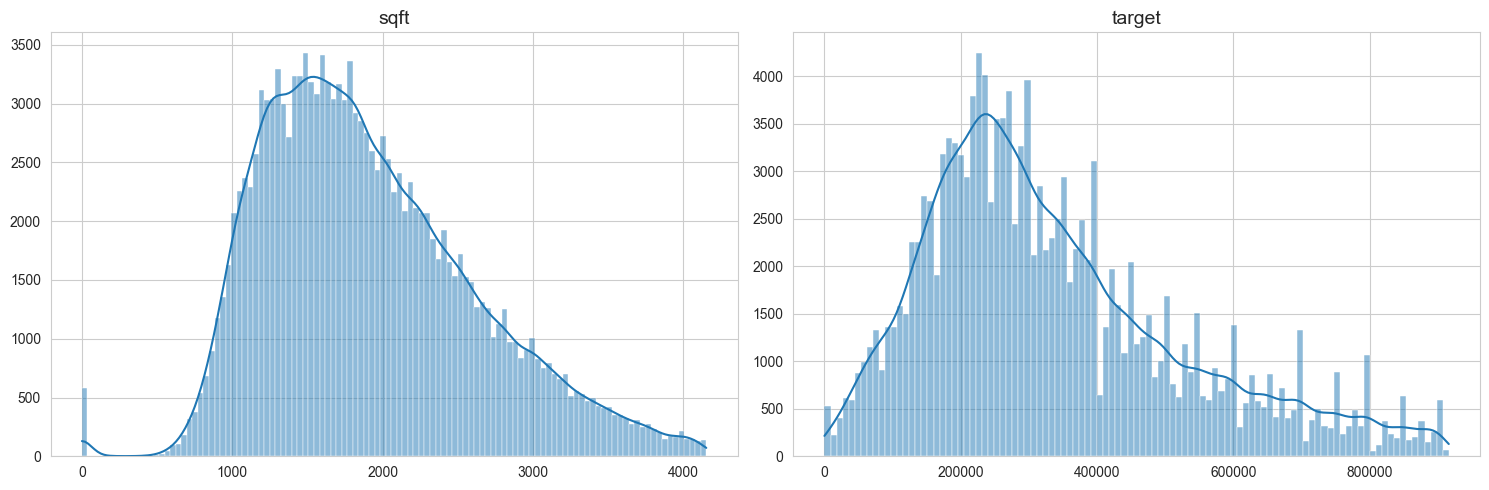

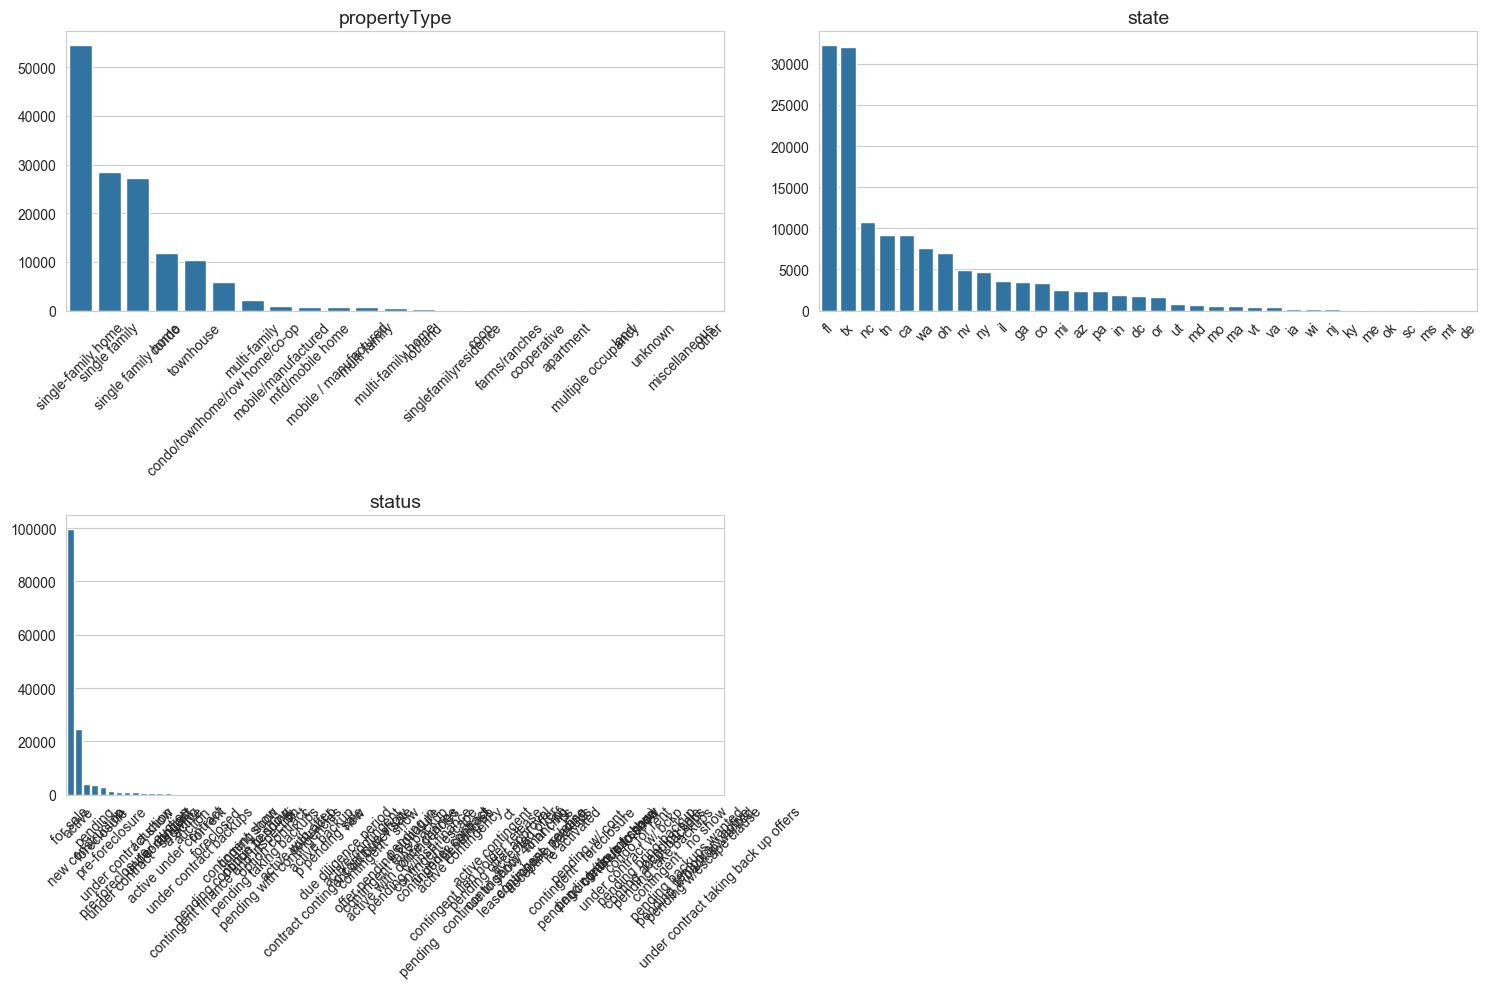

In [19]:
# Задание эстетического стиля
sns.set_style("whitegrid")

# Отдельные числовые и категориальные столбцы
numeric_cols = df_cleaned[['sqft', 'target']].columns
object_cols = df_cleaned[['propertyType', 'state', 'status']].columns

# Постройте гистограммы для числовых столбцов
fig, axes = plt.subplots(nrows=(len(numeric_cols) // 2 + len(numeric_cols) % 2), ncols=2, figsize=(15, 5 * ((len(numeric_cols) // 2 + len(numeric_cols) % 2))))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.histplot(df_cleaned[col], ax=axes[i], kde=True)
    axes[i].set_title(col, fontsize=14)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    
# Скрыть все неиспользуемые 
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# Графики количества графиков для категориальных столбцов
fig, axes = plt.subplots(nrows=(len(object_cols) // 2 + len(object_cols) % 2), ncols=2, figsize=(15, 5 * ((len(object_cols) // 2 + len(object_cols) % 2))))
axes = axes.flatten()

for i, col in enumerate(object_cols):
    # Получите количество каждой категории
    category_counts = df_cleaned[col].value_counts()
    # Сортировать категории по частоте
    sorted_categories = category_counts.index
    sns.countplot(x=df_cleaned[col], ax=axes[i], order=sorted_categories)
    axes[i].set_title(col, fontsize=14)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', rotation=45)  # Поворот меток оси X

# Скрыть все неиспользуемые 
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## Выводы:
Распределение площади (sqft):

График слева вверху отображает распределение площади (sqft) для объектов недвижимости. Видно, что распределение напоминает нормальное распределение с пиком около 1500-2000 квадратных футов. Большинство объектов имеют площадь в этом диапазоне, и наблюдается постепенное снижение частоты с увеличением площади.
Распределение цен (target):

График справа вверху показывает распределение цен на недвижимость. Здесь распределение асимметричное, с длинным "хвостом" вправо. Это означает, что большинство объектов недвижимости находятся в низком и среднем ценовом сегменте (около 200 000–300 000 долларов), но есть несколько объектов с очень высокими ценами (до 800 000 долларов и выше).
Распределение типов недвижимости (propertyType):

График внизу слева отображает количество объектов по типу недвижимости. Видно, что большинство объектов — это "single family" (односемейные дома), за ними следуют "townhouse" и "condominium". Остальные типы недвижимости встречаются значительно реже.
Распределение по штатам (state):

График внизу справа показывает распределение объектов по штатам. Основная масса недвижимости сосредоточена в одном штате (FL), за которым следуют GA и VA. Остальные штаты представлены гораздо меньшим количеством объектов.
Распределение статусов (status):

График на втором изображении внизу отображает статус недвижимости. Видно, что большинство объектов находятся в статусе "for sale" (на продаже), а остальные статусы встречаются крайне редко.
Выводы:
Площадь большинства объектов варьируется от 1000 до 3000 квадратных футов, что соответствует типичным размерам домов.
Цены на недвижимость в большинстве случаев не превышают 400 000 долларов, что указывает на преобладание среднего ценового сегмента.
Типы недвижимости сосредоточены в основном на односемейных домах, что логично для большинства жилых районов.
Географическое распределение показывает значительное присутствие объектов в одном конкретном штате (FL), что может указывать на фокус или ограничения датасета.
Статус объектов свидетельствует о том, что большая часть недвижимости находится в активной продаже.

### Двумерный анализ

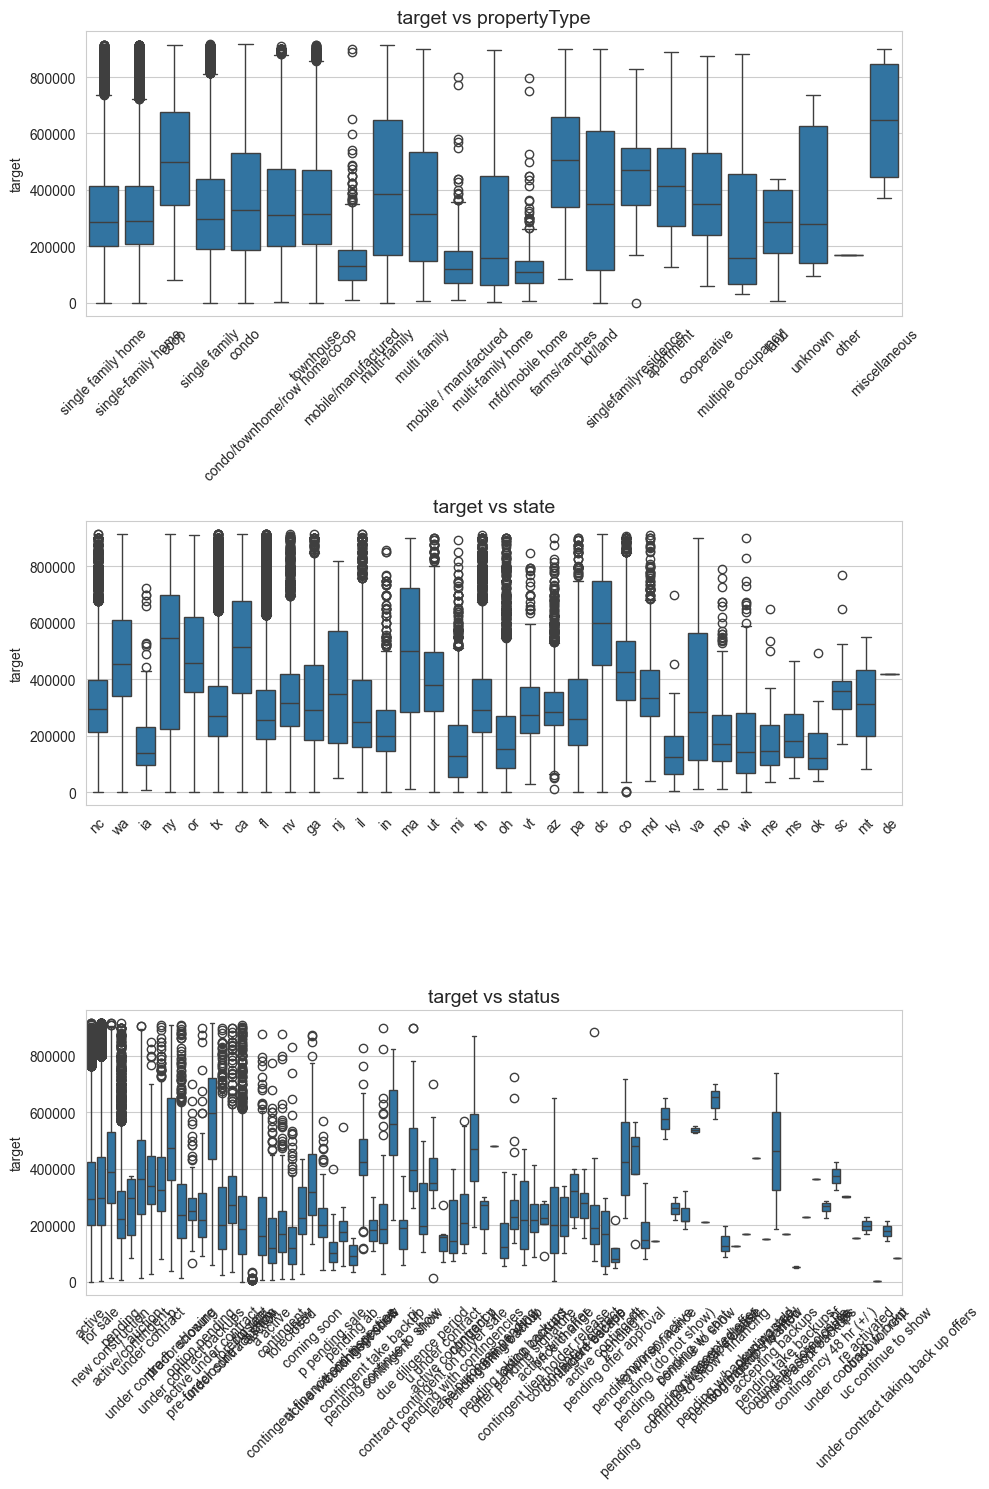

In [20]:
# Задание эстетического стиля
sns.set_style("whitegrid")

# Отдельные числовые и категориальные столбцы
numeric_cols = ['target']
object_cols = df_cleaned[['propertyType', 'state', 'status']].columns

# Создайте коробчатые диаграммы для каждой числовой переменной по всем категориальным переменным.
for num_col in numeric_cols:
    fig, axes = plt.subplots(nrows=len(object_cols), ncols=1, figsize=(10, 5 * len(object_cols)))
    
    # Если есть только одна категориальная переменная, оси не будут массивом.
    if len(object_cols) == 1:
        axes = [axes]

    for i, cat_col in enumerate(object_cols):
        sns.boxplot(x=df_cleaned[cat_col], y=df_cleaned[num_col], ax=axes[i])
        axes[i].set_title(f'{num_col} vs {cat_col}', fontsize=14)
        axes[i].set_xlabel('')
        axes[i].set_ylabel(num_col)
        axes[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels
    
    plt.tight_layout()
    plt.show()


## Выводы 
рассмотрим каждый из них:

График "target vs propertyType" (цена против типа недвижимости):

На этом графике видно, что цена (target) различается в зависимости от типа недвижимости.
Односемейные дома (single family home), как правило, имеют широкий диапазон цен с медианой около 300 000–400 000 долларов, но могут доходить до 800 000 долларов и выше.
Кондо (condo) имеют более низкую медиану цен и меньший разброс, что указывает на то, что эти объекты более доступны.
Cooperative (кооперативы) и mobile homes (мобильные дома) имеют низкие медианы цен, что соответствует ожиданиям для этих типов объектов.
Miscellaneous и multi-family home (многофамильные дома) показывают самый широкий разброс цен, что может быть связано с разнообразием объектов в этих категориях.
График "target vs state" (цена против штата):

Здесь показано, как цены варьируются в зависимости от штата.
Видно, что в некоторых штатах, таких как CA (Калифорния) и NY (Нью-Йорк), цены на недвижимость имеют значительно более высокий медианный уровень и разброс, чем в других штатах.
В некоторых штатах, таких как NC и GA, цены имеют более узкий диапазон и значительно меньшие медианы.
Некоторые штаты, такие как NV и CO, также показывают высокий разброс цен, что может быть связано с разнообразием рынка недвижимости в этих регионах.
График "target vs status" (цена против статуса недвижимости):

Этот график показывает, как цены варьируются в зависимости от статуса недвижимости.
New construction (новостройки) и pre-foreclosure (предварительное обращение взыскания) имеют высокие медианы цен, что может указывать на дороговизну новостроек и потенциальные сделки с высокими ценами в стадии предвзыскания.
Under contract и pending показывают более узкие диапазоны цен, что может указывать на более стабильные цены на этих стадиях сделки.
Sold (продано) показывает широкий разброс, что соответствует разнообразию цен на уже проданные объекты.
Выводы:
Тип недвижимости и географическое расположение оказывают значительное влияние на стоимость недвижимости. Наибольшие медианы цен наблюдаются для односемейных домов в штатах с высокими ценами на жилье, таких как Калифорния и Нью-Йорк.
Различные статусы объектов также влияют на цену, при этом новостройки и объекты в стадии предвзыскания обычно стоят дороже.

## Выбор функции



In [21]:
# подготовка данных
# Преобразование категориальных столбцов в фиктивные переменные, исключая «регион»
df_dummies = pd.get_dummies(df_cleaned, columns=df_cleaned.select_dtypes(include=['object']).columns.difference(['PrivatePool']), drop_first=True)

df_dummies

,baths,fireplace,sqft,beds,stories,PrivatePool,target,propertyType_condo,propertyType_condo/townhome/row home/co-op,propertyType_coop,...,status_re activated,status_temporary active,status_u under contract,status_uc continue to show,status_under contract,status_under contract showing,status_under contract backups,status_under contract show,status_under contract taking back up offers,status_under contract w/ bckp
0,3.0,0,2900.0,4.0,0,0.0,418000.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,3.0,0,1947.0,3.0,2,0.0,310000.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8,2.0,0,3588.0,3.0,0,0.0,244900.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10,2.0,0,1300.0,3.0,0,0.0,669000.0,False,False,True,...,False,False,False,False,False,False,False,False,False,False
13,2.0,0,1820.0,3.0,1,0.0,499900.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377172,2.0,0,1907.0,3.0,1,0.0,287999.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
377173,3.0,1,2505.0,5.0,2,0.0,384900.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
377175,3.0,1,1792.0,4.0,2,0.0,280000.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
377179,3.0,0,1417.0,2.0,3,0.0,799000.0,True,False,False,...,False,False,False,False,False,False,False,False,False,False


In [22]:
# Подготовка значений X и y для модели случайного леса
X = df_dummies.drop(columns=['PrivatePool', 'target'])  # Функции
y = df_dummies['target'] # Целевая переменная

# Разделение набора данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание и обучение модели случайного леса
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Делаем прогнозы на тестовом наборе
y_pred = rf_model.predict(X_test)

# Вычисление среднеквадратической ошибки (MSE) для прогнозов
mse = mean_squared_error(y_test, y_pred)
mse

17154357259.987413

In [23]:
# Извлечение важности функций из обученной модели случайного леса
feature_importances_rf = pd.Series(rf_model.feature_importances_, index=X.columns)

# Сортировка важности функций в порядке убывания
sorted_feature_importances_rf = feature_importances_rf.sort_values(ascending=False)

sorted_feature_importances_rf

sqft                                 3.382643e-01
baths                                1.369571e-01
state_ca                             6.903936e-02
stories                              5.730235e-02
state_wa                             4.082553e-02
                                         ...     
status_pending   continue to show    3.692760e-08
status_pending take backups          1.667234e-08
status_condo for rent                0.000000e+00
status_contingent   foreclosure      0.000000e+00
state_de                             0.000000e+00
Length: 140, dtype: float64

## Настройка гиперпараметра с использованием случайного леса

Настройка гиперпараметров включает в себя настройку параметров модели машинного обучения для оптимизации ее производительности. Ключевые гиперпараметры случайного лесного регрессора включают в себя:

- n_estimators: количество деревьев в лесу.
- max_features: количество функций, которые следует учитывать при поиске лучшего разделения.
- max_глубина: максимальная глубина деревьев.
- min_samples_split: минимальное количество выборок, необходимое для разделения внутреннего узла.
- min_samples_leaf: минимальное количество выборок, которое должно находиться на конечном узле.

Мы можем использовать такие методы, как поиск по сетке или случайный поиск, для систематического изучения комбинаций этих параметров. Для демонстрации мы воспользуемся поиском по сетке, чтобы найти наилучшую комбинацию нескольких из этих гиперпараметров.

In [24]:
# Подготовка значений X и y для модели случайного леса
X = df_dummies.drop(columns=['sqft', 'baths', 'state_ca','stories','state_wa'])  # Функции
y = df_dummies['target'] # Целевая переменная

# Разделение набора данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание и обучение модели случайного леса
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Делаем прогнозы на тестовом наборе
y_pred = rf_model.predict(X_test)

# Вычисление среднеквадратической ошибки (MSE) для прогнозов
mse = mean_squared_error(y_test, y_pred)
mse

516.7142241238696

In [25]:
# Определение сетки параметров для настройки гиперпараметров
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Создание базовой модели для настройки
rf = RandomForestRegressor(random_state=42)

# Создание экземпляра модели поиска по сетке
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Подгонка поиска по сетке к данным
grid_search.fit(X_train, y_train)

# Получение лучших параметров
best_params = grid_search.best_params_
best_params

Fitting 3 folds for each of 216 candidates, totalling 648 fits


{'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}


Поиск по сетке для настройки гиперпараметров случайного лесного регрессора в наборе жилищных данных Бостона завершился, в результате чего было оценено в общей сложности 216 различных комбинаций в 3 сгибах. Лучшими найденными параметрами являются:

- max_length: 10 (Максимальная глубина деревьев)
- max_features: 'sqrt' (количество объектов, которые следует учитывать при поиске наилучшего разделения, равно квадратному корню из общего количества объектов)
- min_samples_leaf: 1 (минимальное количество выборок, которое должно находиться в конечном узле)
- min_samples_split: 5 (минимальное количество выборок, необходимое для разделения внутреннего узла)
- n_estimators: 200 (Количество деревьев в лесу)

Ожидается, что эти оптимизированные гиперпараметры дадут модель случайного леса с улучшенной производительностью прогнозирования по сравнению с настройками по умолчанию.

In [26]:
# Создание и обучение модели с лучшими параметрами
optimized_rf_model = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    max_features=best_params['max_features'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)
optimized_rf_model.fit(X_train, y_train)

# Делаем прогнозы на тестовом наборе с помощью оптимизированной модели
optimized_y_pred = optimized_rf_model.predict(X_test)

# Вычисление среднеквадратической ошибки (MSE) для оптимизированных прогнозов
optimized_mse = mean_squared_error(y_test, optimized_y_pred)
optimized_mse

63696541.56979384

Настройка гиперпараметра улучшает модель, поскольку MSE уменьшается.

Веб сервис

In [27]:
import pickle

In [28]:
# Сохранение обученной модели в файл
with open('optimized_rf_model.pkl', 'wb') as f:
    pickle.dump(optimized_rf_model, f)
    
print()